<a href="https://colab.research.google.com/github/Arifuzzaman-Munaf/lung-disease-classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Initial Configuration

In the initial configuration, Google Drive was mounted using drive.mount('/content/drive') to connect Colab’s temporary runtime with persistent cloud storage. This step is necessary because files stored directly in Colab are deleted once the session ends, while Drive provides a permanent location for datasets, scripts, model checkpoints, and outputs. Mounting enables seamless access to files under /content/drive/MyDrive/, allowing datasets to be loaded, results to be saved, and project resources to be organized in a consistent location. This configuration ensures persistence, reproducibility, and efficient handling of large datasets without repeated uploads.

In [1]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The system path was updated by appending the project directory located in Google Drive (/content/drive/MyDrive/DLE602) to sys.path. This was done to ensure that Python recognizes the folder as a valid source for modules and packages, allowing scripts and custom code stored in that directory to be imported directly into the Colab environment. Without this step, Python would not automatically search the Google Drive project folder when resolving imports, making it necessary to adjust the path manually for seamless integration and modular code reuse.

In [2]:
import sys

# Define the project directory in Google Drive
SKELETON_DIR  = '/content/drive/MyDrive/DLE602'

# Add the project directory to Python's module search path.
# This allows direct importing of custom modules and scripts
# located in the DLE602 folder without changing the working directory.
if SKELETON_DIR not in sys.path:
    sys.path.append(SKELETON_DIR)

IPython was upgraded to the latest version using !pip3 install -q --upgrade ipython to ensure compatibility with modern Python releases and avoid issues related to deprecated modules. Following the upgrade, the %load_ext autoreload and %autoreload 2 magic commands were enabled in the Colab environment. This configuration allows Python modules to be automatically reloaded before executing code, ensuring that any changes made to external scripts or project files are immediately reflected during runtime. Such a setup streamlines the development workflow by eliminating the need to restart the kernel or manually reload modules after each modification.

In [4]:
!pip3 install -q --upgrade ipython

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# installing required libraries
!pip3 install -q -r {SKELETON_DIR}/requirements.txt

In [51]:
# Import necessary libraries
import torch
import numpy as np
import pandas as pd
from config import CFG

# set configuration path and data for project
cfg = CFG(SKELETON_DIR)

# Set benchmark to True for performance improvements in cuDNN
torch.backends.cudnn.benchmark = True

# Determine the device to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set the default figure size for matplotlib plots
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

# 1. Dataset: Lung X-Ray Image with Clinical Text
The Lung X-Ray Image and Clinical Text Dataset is a multimodal resource hosted on Kaggle that pairs chest X-ray images with corresponding clinical text reports. It is specifically designed to facilitate research in medical image analysis, natural language processing, and multimodal learning. Each sample consists of a radiographic image and a clinical description, enabling tasks such as disease classification from images, report generation from imaging data, and joint image–text representation learning. The dataset covers a wide spectrum of pulmonary conditions, making it suitable for both supervised and unsupervised diagnostic modeling. The dataset can accessible in - https://www.kaggle.com/datasets/ghostbat101/lung-x-ray-image-clinical-text-dataset

**Content Overview**
- Images: High-quality chest X-ray scans, organized by disease categories.
- Clinical Reports: Corresponding textual descriptions which were generated from GPT-3.5 and medical publications highlighting symptoms and key findings.

**Disease Categories Included (eight total)**:
1.	Obstructive Pulmonary Diseases (e.g., COPD, bronchitis)
2.	Higher Density (indicates areas of increased lung opacity)
3.	Lower Density (suggestive of emphysema or air trapping)
4.	Chest Changes (general structural or textural abnormalities)
5.	Encapsulated Lesions (such as nodules or masses with clear margins)
6.	Degenerative Infectious Diseases (e.g., TB-related structural changes)
7.	Normal (absence of pathology)
8.	Mediastinal Changes (alterations in mediastinal contours, lymphadenopathy)

These categories support both uniform classification tasks and zero-shot diagnosis via descriptive prompts.


To load dataset in the project, two essential steps were conducted using bash script

First, it checks whether the dataset archive (lung-x-ray-image-clinical-text-dataset.zip) is already present locally. If the file is missing, the script automatically downloads it from the URL specified in the configuration (cfg.data_url) using curl. This conditional approach prevents redundant downloads and ensures efficient use of resources.

Second, the script verifies whether the dataset has already been extracted into a dedicated folder named dataset. If the folder is missing or empty, it removes any existing directory, recreates it, and unzips the archive into this location. This step guarantees that the dataset is properly unpacked and accessible in a clean directory structure.

Together, these steps automate dataset acquisition and extraction, ensuring reproducibility, consistency, and streamlined setup for subsequent data processing and analysis.

In [52]:
# Run bash with URL from data_url variable to download dataset
!if [ ! -f "./lung-x-ray-image-clinical-text-dataset.zip" ]; then \
    echo "Dataset not found locally. Downloading..."; \
    curl -L -o ./lung-x-ray-image-clinical-text-dataset.zip "$cfg.data_url"; \
  else \
    echo "Dataset already exists. Skipping download."; \
  fi

Dataset already exists. Skipping download.


In [53]:
# extracting the zip of dataset in a folder for easier access
%%bash
if [ ! -d "dataset" ] || [ -z "$(ls -A dataset)" ]; then
    echo "Extracting dataset..."
    rm -rf dataset
    mkdir dataset
    unzip -q -o lung-x-ray-image-clinical-text-dataset.zip -d dataset/
else
    echo "Dataset folder already exists. Skipping extraction."
fi

Dataset folder already exists. Skipping extraction.


In [54]:
import utils

# create a dataframe of image dataset
df_merged = utils.create_dataframe(cfg.merged_dataset_path)
df_merged.head()

,path,label
0,/content/dataset/Merged Data (image+text)/Obst...,Obstructive Pulmonary Diseases
1,/content/dataset/Merged Data (image+text)/Obst...,Obstructive Pulmonary Diseases
2,/content/dataset/Merged Data (image+text)/Obst...,Obstructive Pulmonary Diseases
3,/content/dataset/Merged Data (image+text)/Obst...,Obstructive Pulmonary Diseases
4,/content/dataset/Merged Data (image+text)/Obst...,Obstructive Pulmonary Diseases


In [55]:
# give an overview of dataset
utils.dataset_overview(df_merged)

Number of rows: 80000

Unique values per column:
image_id    80000
label           8
dtype: int64 

Label distribution:
label
Obstructive Pulmonary Diseases      10000
Degenerative Infectious Diseases    10000
Chest Changes                       10000
Lower Density                       10000
Mediastinal Changes                 10000
Normal                              10000
Encapsulated Lesions                10000
Higher Density                      10000
Name: count, dtype: int64 

Full DataFrame summary:
                                image_id                           label
count                              80000                           80000
unique                             80000                               8
top     1b16d2708acc7eea929c49badc42ca63  Obstructive Pulmonary Diseases
freq                                   1                           10000


The dataset contains 80,000 chest X-ray samples, each with a unique image_id and an associated label spanning 8 lung disease categories. Each category is represented by exactly 10,000 images, ensuring a perfectly balanced distribution across disease classes. This balanced composition makes the dataset well-suited for classification tasks and fair model evaluation across all disease types.

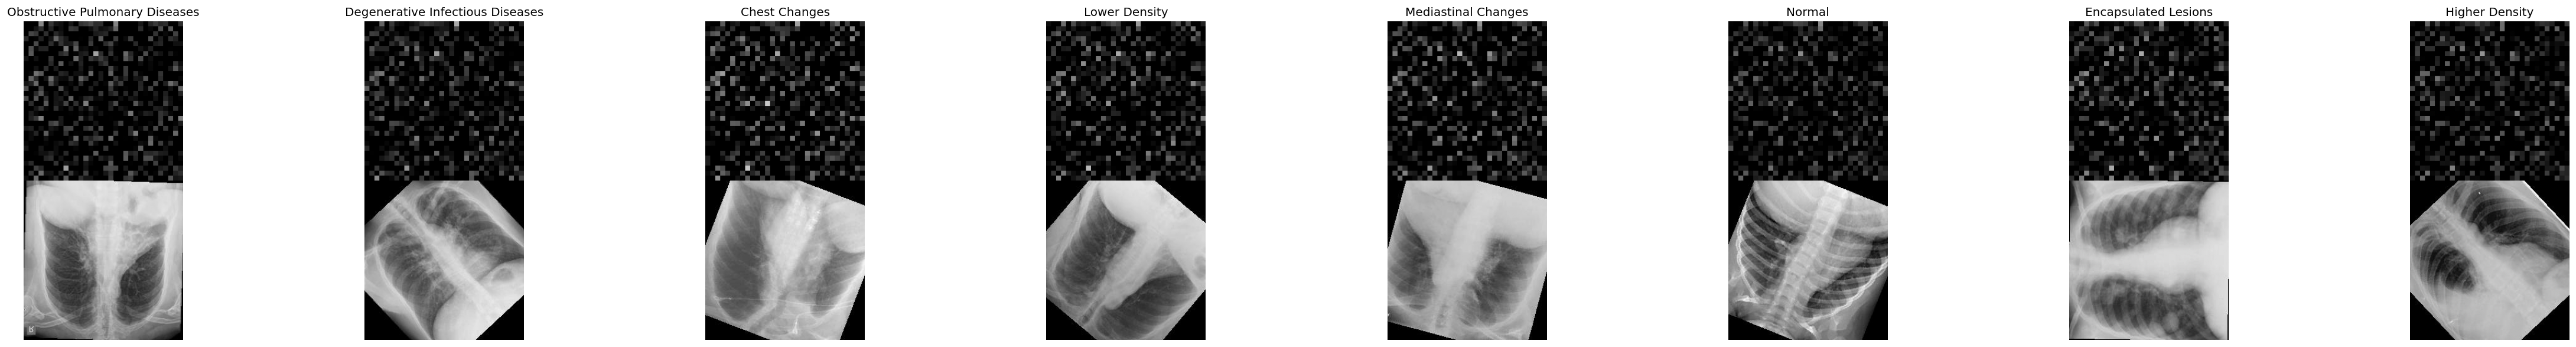

In [56]:
# show index wise one sample from each class
utils.show_images(df_merged)

In this step, the merged dataset was used as the source, and a balanced subset was created for experimentation. The parameter samples_per_class was set to 2000, ensuring that exactly 2000 samples were drawn from each of the eight disease categories. By applying groupby("label"), the sampling process was carried out class-wise, maintaining equal representation across all labels. A fixed random_state=42 was specified to guarantee reproducibility of the selection. After sampling, the index was reset for consistency, and value_counts() along with the total count were printed to verify that each class contained 2000 samples, resulting in a total of 16,000 samples.

This approach ensures that the merged dataset is utilized effectively while reducing its size for faster experimentation, preserving class balance, and enabling fair model training and evaluation across all categories.

In [57]:
# initally 1000 samples from each class have been taken
samples_per_class = 2000

# Group by label and sample
df_merged_samples = (
    df_merged.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=samples_per_class, random_state=42))
      .reset_index(drop=True)
)

# Verify 1000 per class
print(df_merged_samples['label'].value_counts())
print(f"Total samples: {len(df_merged_samples)}")

label
Chest Changes                       2000
Degenerative Infectious Diseases    2000
Encapsulated Lesions                2000
Higher Density                      2000
Lower Density                       2000
Mediastinal Changes                 2000
Normal                              2000
Obstructive Pulmonary Diseases      2000
Name: count, dtype: int64
Total samples: 16000


/tmp/ipython-input-3352591159.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=samples_per_class, random_state=42))


In [58]:
df_merged_samples.head()

,path,label
0,/content/dataset/Merged Data (image+text)/Ches...,Chest Changes
1,/content/dataset/Merged Data (image+text)/Ches...,Chest Changes
2,/content/dataset/Merged Data (image+text)/Ches...,Chest Changes
3,/content/dataset/Merged Data (image+text)/Ches...,Chest Changes
4,/content/dataset/Merged Data (image+text)/Ches...,Chest Changes


In [59]:
# creating image only data from the merged samples
df_image = utils.create_image_dataframe(df_merged_samples)
df_image.head()

,path,label
0,/content/dataset/Main dataset/Chest Changes/im...,Chest Changes
1,/content/dataset/Main dataset/Chest Changes/im...,Chest Changes
2,/content/dataset/Main dataset/Chest Changes/im...,Chest Changes
3,/content/dataset/Main dataset/Chest Changes/im...,Chest Changes
4,/content/dataset/Main dataset/Chest Changes/im...,Chest Changes


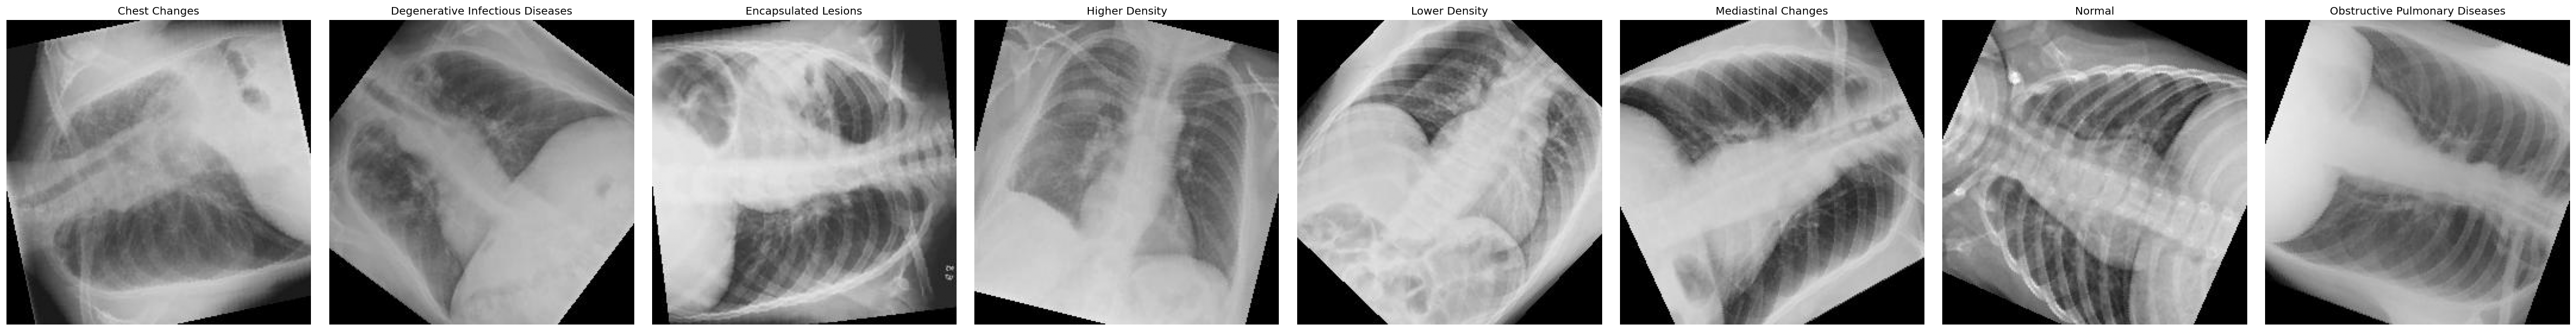

In [60]:
utils.show_images(df_image)

Unlike the merged dataset that combines both image and clinical text information, this view is derived from the image-only data, meaning that corresponding text embeddings are not included here. The focus is therefore not only the merged data but also the radiographic features, providing a clear inspection of visual variations across different diagnostic classes without leveraging the complementary textual descriptions.

## 1.1 Label Encoding
In this step, the categorical disease labels were transformed into numerical form using the LabelEncoder from scikit-learn, which is needed because most machine learning and deep learning models require numeric rather than textual inputs for classification. The encoder was first fitted on the complete set of class labels and then applied consistently to both the merged dataset samples and the image-only dataset to maintain uniform encoding across subsets. A mapping of the original class names to their assigned integer values was generated to provide clarity and traceability of the transformation. Finally, a random sample of rows was displayed to verify that the encoding had been applied correctly. This transformation is an essential preprocessing step, ensuring that the categorical labels are standardized and model-ready for efficient training and evaluation.

In [61]:
from sklearn.preprocessing import LabelEncoder

# create instance of label encoder
le = LabelEncoder()

# Fit the encoder and transform labels for both dataset
df_merged_samples['label'] = le.fit_transform(df_merged_samples['label'])
df_image['label'] = le.transform(df_image['label'])

# Check mapping of class label
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", *label_mapping.items(), sep="\n")

# Show 5 random rows from df_merged_samples
df_merged_samples.sample(10, random_state=None)

Label Mapping:
('Chest Changes', np.int64(0))
('Degenerative Infectious Diseases', np.int64(1))
('Encapsulated Lesions', np.int64(2))
('Higher Density', np.int64(3))
('Lower Density', np.int64(4))
('Mediastinal Changes', np.int64(5))
('Normal', np.int64(6))
('Obstructive Pulmonary Diseases', np.int64(7))


,path,label
8258,/content/dataset/Merged Data (image+text)/Lowe...,4
3299,/content/dataset/Merged Data (image+text)/Dege...,1
5322,/content/dataset/Merged Data (image+text)/Enca...,2
9452,/content/dataset/Merged Data (image+text)/Lowe...,4
778,/content/dataset/Merged Data (image+text)/Ches...,0
15912,/content/dataset/Merged Data (image+text)/Obst...,7
11680,/content/dataset/Merged Data (image+text)/Medi...,5
11437,/content/dataset/Merged Data (image+text)/Medi...,5
112,/content/dataset/Merged Data (image+text)/Ches...,0
7647,/content/dataset/Merged Data (image+text)/High...,3


# 2. Data Exploration

## 2.1 Image Dimension and Color Mode Analysis
In this step, the dataset was examined to understand the image characteristics in terms of size and color mode. Using the Python Imaging Library (PIL), the file paths in the dataset were accessed to extract metadata for each image. Specifically, the dimensions (width and height) of every image were retrieved to analyze the size distribution across the dataset, while the color mode (e.g., 'L' for grayscale or 'RGB' for color) was extracted to identify the format in which the images are stored. The results were summarized using frequency counts, providing an overview of how consistent the dataset is in terms of image resolution and representation. This analysis is a critical preprocessing step, as it helps determine whether resizing or color-space normalization is required to standardize the inputs before training machine learning or deep learning models.

In [62]:
from PIL import Image

# get image size (width, height) from file paths
sizes = df_merged_samples['path'].apply(lambda p: Image.open(p).size)

# get image color mode from file paths (e.g., 'L', 'RGB')
modes = df_merged_samples['path'].apply(lambda p: Image.open(p).mode)
print("\nImage size distribution:")
print(sizes.value_counts())

print("\nImage mode distribution:")
print(modes.value_counts())


Image size distribution:
path
(256, 512)    16000
Name: count, dtype: int64

Image mode distribution:
path
L    16000
Name: count, dtype: int64


The results show that the merged dataset is highly consistent in both image size and color mode:
- **Image size distribution:** All 16,000 images have the exact same resolution of 256 × 512 pixels. This uniformity means that no resizing or cropping is required during preprocessing, simplifying the data pipeline and ensuring consistent input dimensions for the model.
- **Image mode distribution:** All 16,000 images are in L mode, which corresponds to grayscale. This indicates that the X-ray scans are single-channel images, as expected in medical imaging, and do not contain RGB color information.

In [63]:
from PIL import Image


# get image size (width, height) from file paths
sizes = df_image['path'].apply(lambda p: Image.open(p).size)

# get image color mode from file paths (e.g., 'L', 'RGB')
modes = df_image['path'].apply(lambda p: Image.open(p).mode)

print("\nImage size distribution:")
print(sizes.value_counts())

print("\nImage mode distribution:")
print(modes.value_counts())


Image size distribution:
path
(256, 256)    16000
Name: count, dtype: int64

Image mode distribution:
path
L      9207
RGB    6793
Name: count, dtype: int64


The results indicate the characteristics of the image-only dataset:
- **Image size distribution:** All 16,000 images share the same resolution of 256 × 256 pixels, showing that the dataset is standardized in terms of dimensions. This uniformity removes the need for resizing operations during preprocessing and ensures that all samples can be directly fed into the model.
- **Image mode distribution:** Out of the total, 9,207 images are in L mode (grayscale), while 6,793 images are in RGB mode (three-channel color). Since chest X-ray scans are inherently grayscale, the presence of RGB images likely reflects cases where grayscale data has been stored with three identical channels.

In summary, while the dataset is consistent in size, the mixed color modes suggest that preprocessing will be required to unify the image format by converting all images to grayscale or standardizing them into three channels before training deep learning models. This step is necessary to maintain input consistency and avoid errors during batch processing.

## 2.2 Data Imbalanace

Merged Set distribution in percentage:
Degenerative Infectious Diseases --> 12.50%
Encapsulated Lesions --> 12.50%
Obstructive Pulmonary Diseases --> 12.50%
Higher Density --> 12.50%
Mediastinal Changes --> 12.50%
Normal --> 12.50%
Lower Density --> 12.50%
Chest Changes --> 12.50%
The Merged set properly balanced


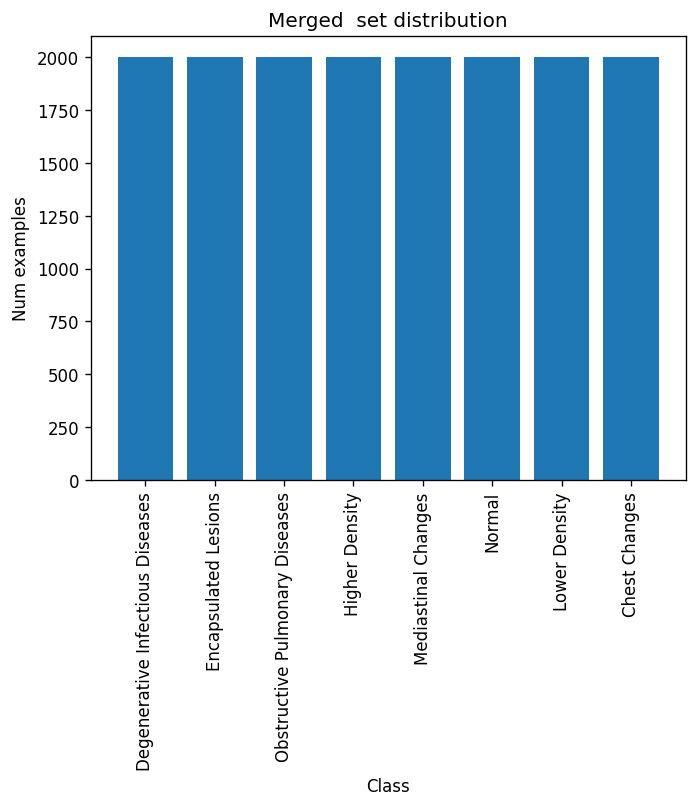

In [64]:
import explore

# class labels of all samples
labels = df_merged_samples['label']

# check data imbalance and present in proportion
explore.check_df_imbalance(labels, cfg.class_names, "Merged")

# plot data distribution
explore.plot_label_distribution(labels, cfg.class_names, "Merged ")

Only Image Set distribution in percentage:
Degenerative Infectious Diseases --> 12.50%
Encapsulated Lesions --> 12.50%
Obstructive Pulmonary Diseases --> 12.50%
Higher Density --> 12.50%
Mediastinal Changes --> 12.50%
Normal --> 12.50%
Lower Density --> 12.50%
Chest Changes --> 12.50%
The Only Image set properly balanced


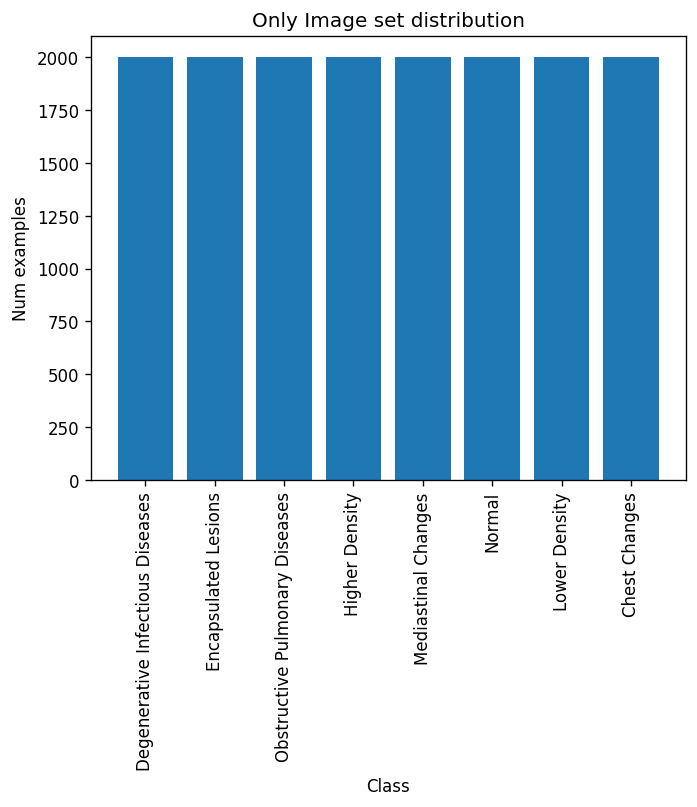

In [65]:
# class labels of all samples
labels = df_image['label']

# check data imbalance and present in proportion
explore.check_df_imbalance(labels, cfg.class_names, "Only Image")

# plot data distribution
explore.plot_label_distribution(labels, cfg.class_names, "Only Image")

## 2.2 Duplicates

In [66]:
explore.compute_duplicate(df_merged_samples)

Total rows: 16000
Duplicate rows (excluding first occurrences): 0
Duplicate groups : 0

Class-wise duplicate rows:
No  duplicates found.


In [67]:
explore.compute_duplicate(df_image)

Total rows: 16000
Duplicate rows (excluding first occurrences): 0
Duplicate groups : 0

Class-wise duplicate rows:
No  duplicates found.


## 2.3 Pixel Intensity Statistics
In this step, a comprehensive pixel intensity analysis was performed for both the merged dataset (image + text composites) and the image-only dataset to assess image quality and consistency. For each dataset, the function pixel_stats_overall was used to compute global statistics such as mean, standard deviation, and intensity range, offering insight into overall brightness and contrast distribution. The function pixel_stats_by_class was then applied to calculate the same statistics separately for each disease category, based on representative samples of 200 images per class, enabling the detection of class-specific variations in pixel intensity that could affect model training. Finally, plot_pixel_histogram was employed to visualize the distribution of mean pixel intensities for 500 randomly selected images, providing an intuitive comparison of brightness characteristics across datasets. This analysis was carried out to ensure that both the merged and image-only datasets are consistent in their intensity distributions and to determine whether preprocessing steps such as normalization, contrast adjustment, or histogram equalization are necessary. By addressing both datasets, the analysis guarantees standardized inputs and reduces the risk of bias in subsequent multimodal and image-only modeling.


Overall Pixel Intensity Statistics (grayscale)
 count: 2097152000
   min: 0.0
   max: 255.0
  mean: 71.02727202177047
   std: 73.29739694935739
   class     count  min    max       mean        std
0      0  26214400  0.0  255.0  69.527472  71.749345
1      1  26214400  0.0  255.0  68.672264  70.818988
2      2  26214400  0.0  255.0  70.460461  72.475670
3      3  26214400  0.0  255.0  74.125663  77.588210
4      4  26214400  0.0  255.0  72.076434  73.135171
5      5  26214400  0.0  255.0  68.323614  70.143970
6      6  26214400  0.0  255.0  71.928851  73.508046
7      7  26214400  0.0  255.0  72.817959  75.561474


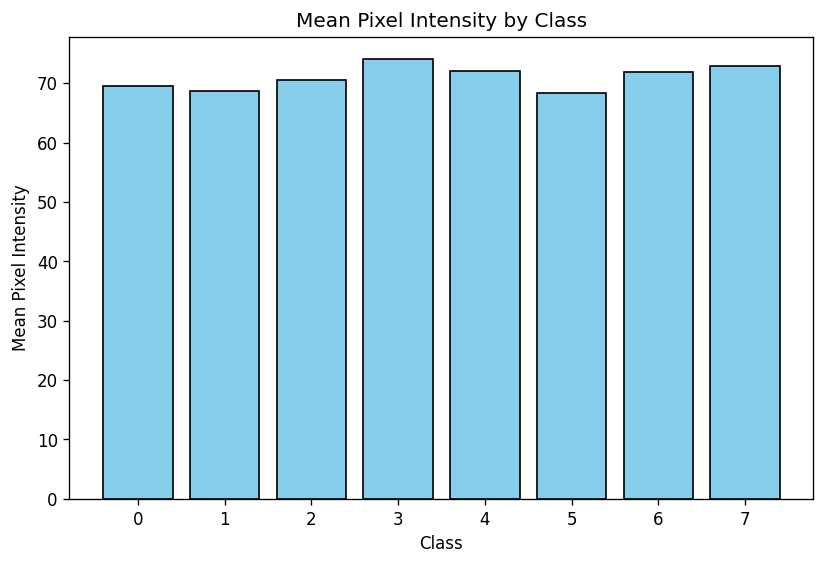

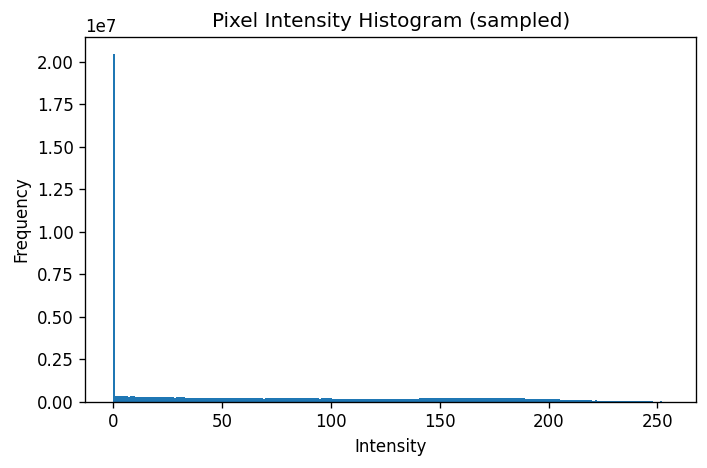

In [68]:
# print pixel intensity statistics
explore.pixel_stats_overall(df_merged_samples, path_col="path", as_gray=True)

# class wise pixel statistics
explore.pixel_stats_by_class(
    df_merged_samples, path_col="path",
    label_col="label", as_gray=True,
    sample_per_class=200
    )

# Plot histogram of mean pixel intensity based on selected samples
explore.plot_pixel_histogram(
    df_merged_samples, path_col="path",
    as_gray=True, bins=256, sample=500
    )

**Findings on the Merged Dataset (Image + Text Composites)**

The pixel intensity analysis of the merged dataset provided the following insights:
1.	**Overall Pixel Distribution**
- Pixel intensity values range from 0 to 255, which is consistent with standard grayscale image representation.
- The global mean pixel intensity is approximately ~71.03, with a standard deviation of ~73.29, indicating a moderate spread of brightness levels across the dataset.
- A large proportion of pixels are concentrated at very low intensity values (near zero), as shown in the histogram, suggesting that the images contain significant dark regions or background areas(also shown in image).

2.	**Class-wise Pixel Statistics**
- Across all eight disease categories, the mean pixel intensities are relatively close, ranging from 68.67 (class 1) to 73.82 (class 7).
- The variation among classes is minimal, with standard deviations ranging between ~70 and 76, reflecting that all classes share broadly similar intensity characteristics.
- This consistency indicates that no single class is inherently brighter or darker, reducing the likelihood of class-level intensity bias.

3. **Histogram Observations**
- The histogram of pixel intensities reveals a sharp peak at intensity 0, confirming a high frequency of background pixels across the dataset.
- Apart from the dominance of dark pixels, the distribution is relatively flat across the remaining intensity range, showing that informative regions (lungs and lesions) span multiple brightness levels.


Overall Pixel Intensity Statistics (grayscale)
 count: 1048576000
   min: 0.0
   max: 255.0
  mean: 124.1158245382309
   std: 66.21867628686307
   class     count  min    max        mean        std
0      0  13107200  0.0  255.0  120.990325  65.261273
1      1  13107200  0.0  255.0  119.361858  64.536832
2      2  13107200  0.0  255.0  122.868255  65.473507
3      3  13107200  0.0  255.0  130.328331  70.747536
4      4  13107200  0.0  255.0  126.146515  64.209594
5      5  13107200  0.0  255.0  118.802785  63.384639
6      6  13107200  0.0  255.0  126.186623  64.951756
7      7  13107200  0.0  255.0  127.642137  68.399821


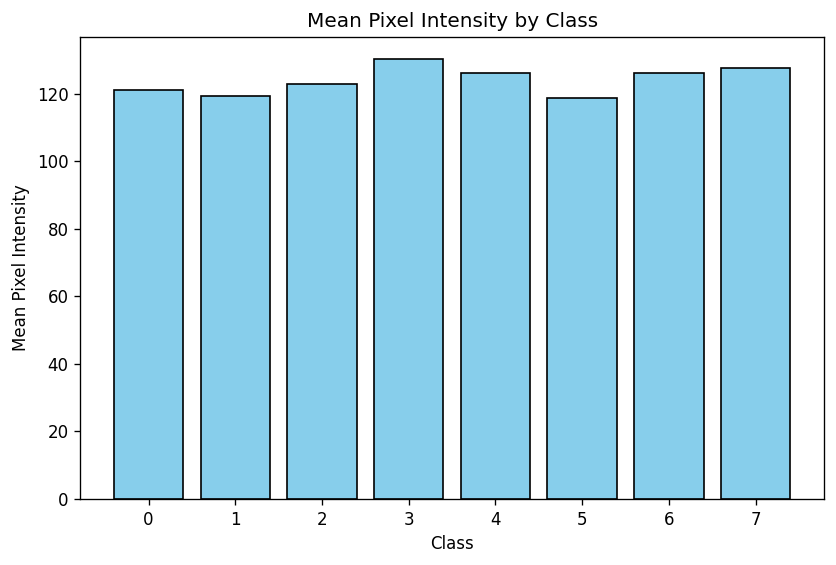

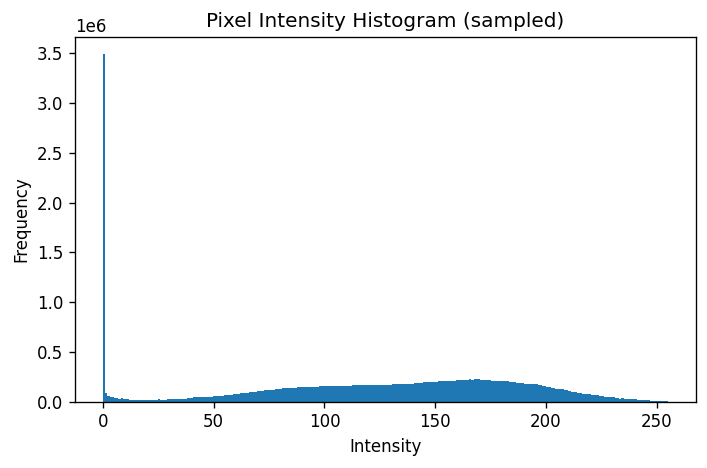

In [69]:
# print pixel intensity statistics
explore.pixel_stats_overall(df_image, path_col="path", as_gray=True)

# class wise pixel statistics
explore.pixel_stats_by_class(
    df_image, path_col="path",
    label_col="label", as_gray=True,
    sample_per_class=200
    )

# Plot histogram of mean pixel intensity based on selected samples
explore.plot_pixel_histogram(
    df_image, path_col="path",
    as_gray=True, bins=256, sample=500
    )

**Findings on the Image-Only Dataset**

The pixel intensity analysis of the image-only dataset highlights the following characteristics:
1.	**Overall Pixel Distribution**
-	Pixel intensities span the full grayscale range from 0 to 255, consistent with standard image encoding.
- The overall mean pixel intensity is approximately ~124.1, with a standard deviation of ~66.2, indicating moderately bright images with a relatively wide spread in brightness levels compared to the merged dataset.
- The histogram shows a pronounced spike near intensity 0, reflecting dark background regions, followed by a broad distribution across mid to high intensities, suggesting richer contrast and more visible anatomical details than the merged dataset.
2.	**Class-wise Pixel Statistics**
- The mean pixel intensity varies slightly across disease categories, ranging from ~118.8 (class 5) to ~130.3 (class 3).
- Standard deviations fall between ~63.4 and ~70.7, showing that all classes share comparable brightness variation, with no extreme outliers.
- The relatively small variation in mean intensity across classes confirms that the dataset is well-balanced in terms of brightness characteristics.
3.	**Histogram Observations**
- Compared to the merged dataset, the histogram demonstrates a broader spread of pixel values across the mid-range intensities ~(100–200), suggesting stronger tissue visibility and greater structural detail in the X-ray images.
- The consistent spread reduces the likelihood of systematic class-level intensity bias and supports robust feature extraction during model training.

# 3. Data Preparation

In [70]:
# Split both the merged dataset and the image-only dataset into
# training, validation, and test subsets.
# This ensures that each dataset is divided consistently for model
# development, hyperparameter tuning, and unbiased performance evaluation.
train_df_merged, val_df_merged, test_df_merged = utils.split_dataset(df_merged_samples)
train_df_image, val_df_image, test_df_image = utils.split_dataset(df_image)

In [71]:
# check imbalance across split
explore.check_df_imbalance(train_df_merged['label'], cfg.class_names, split="Training(merged data)")
print("-"*50)

explore.check_df_imbalance(val_df_merged['label'], cfg.class_names, split="Validation(merged data)")
print("-"*50)

explore.check_df_imbalance(test_df_merged['label'], cfg.class_names, split="Testing(merged data)")

Training(merged data) Set distribution in percentage:
Degenerative Infectious Diseases --> 12.50%
Encapsulated Lesions --> 12.50%
Obstructive Pulmonary Diseases --> 12.50%
Higher Density --> 12.50%
Mediastinal Changes --> 12.50%
Normal --> 12.50%
Lower Density --> 12.50%
Chest Changes --> 12.50%
The Training(merged data) set properly balanced
--------------------------------------------------
Validation(merged data) Set distribution in percentage:
Degenerative Infectious Diseases --> 12.50%
Encapsulated Lesions --> 12.50%
Obstructive Pulmonary Diseases --> 12.50%
Higher Density --> 12.50%
Mediastinal Changes --> 12.50%
Normal --> 12.50%
Lower Density --> 12.50%
Chest Changes --> 12.50%
The Validation(merged data) set properly balanced
--------------------------------------------------
Testing(merged data) Set distribution in percentage:
Degenerative Infectious Diseases --> 12.50%
Encapsulated Lesions --> 12.50%
Obstructive Pulmonary Diseases --> 12.50%
Higher Density --> 12.50%
Mediast

## Data Transformation
In this step, a custom class, ImageDataset, designed to manage chest X-ray images(both merged and image only) and their corresponding pre-encoded labels stored within a DataFrame. The class streamlines data handling by standardizing preprocessing and ensuring compatibility with deep learning models. During initialization, the DataFrame is validated to retain only the required columns, with image file paths stored for efficient access and labels converted to torch.long tensors. A transformation pipeline is applied to each image, which includes resizing to a fixed target size, converting grayscale images to three-channel RGB, tensor conversion, and normalization using ImageNet statistics. When augmentation is enabled, additional transformations such as random horizontal flips, small rotations, and slight contrast adjustments are incorporated to increase variability and improve model generalization. This implementation ensures consistent input dimensions, standardized normalization, and optional augmentation, thereby enabling efficient and robust training of deep learning models on medical imaging data.

In [72]:
from dataset import ImageDataset

ds = ImageDataset(train_df_merged, img_size=cfg.img_size, augment=False)
input, label = ds[0]
print(input)
print(label)

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -1.6898, -1.6898, -1.6898],
         [-2.1179, -2.1179, -2.1179,  ..., -1.6898, -1.6898, -1.6898],
         [-2.1179, -2.1179, -2.1179,  ..., -1.6898, -1.6898, -1.6898],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -1.5980, -1.5980, -1.5980],
         [-2.0357, -2.0357, -2.0357,  ..., -1.5980, -1.5980, -1.5980],
         [-2.0357, -2.0357, -2.0357,  ..., -1.5980, -1.5980, -1.5980],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.3687, -1.3687, -1.3687],
         [-1.8044, -1.8044, -1.8044,  ..., -1

# 4. Model Training
To evaluate performance across different architectures and dataset types, multiple convolutional neural network models were trained under a consistent experimental setup. The training procedure was carried out using both the image-only dataset and the merged dataset (image + text composites) in order to compare performance on unimodal and multimodal representations.

**Training Configuration**

All experiments were conducted using the following hyperparameters:
-	Batch size: 64
-	Epochs: 20
-	Learning rate: 0.001
-	Optimizer: Adam (adaptive moment estimation)
-	Loss function: Cross-Entropy Loss (suitable for multi-class classification)

A fixed random seed (42) was applied to ensure reproducibility. Data was split into training and validation sets, with shuffling enabled for training loaders and disabled for validation loaders.

**Model Architectures Evaluated**
1.	**ResNet50** – A deep residual network with 50 layers, used as a strong baseline model for image classification.
2.	**MobileNetV3-Small** – A lightweight CNN optimized for efficiency, allowing comparison between high-capacity and resource-efficient architectures.
3.	**CustomResidualCNN** – A custom-designed residual convolutional network tailored for the dataset to explore the benefits of a task-specific architecture.

**Experiment Design**

Each model was trained twice:
- **Image-only dataset**: raw X-ray images without accompanying text.
-	**Merged dataset**: composite images combining X-rays with embedded clinical text.

A unique identifier string was constructed for each training run, encoding model type, dataset type, optimizer, loss function, and hyperparameters. This ensured proper experiment tracking and facilitated reproducibility.


**Training Procedure**

For each run, the model was trained for 20 epochs, with performance monitored on the validation set after each epoch. Results, including loss curves, accuracy, and class-level performance metrics, were logged under the project name DLE602_Assessment_3. This systematic training pipeline enabled direct comparison of model capacity, efficiency, and robustness across both dataset modalities.

In [73]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import dataset
import models

# Set fixed random seed for reproducibility
torch.manual_seed(42)

# Training configuration
batch_size = 64
epochs = 20
learning_rate = 0.001


# Create training and validation split for merged dataset using the custom ImageDataset class
# augment=False ensures no random augmentations are applied at this stage
train_ds_merged = ImageDataset(train_df_merged, img_size=cfg.img_size, augment=False)
val_ds_merged = ImageDataset(val_df_merged, img_size=cfg.img_size, augment=False)

# Wrap datasets in DataLoaders
# - Training loader uses shuffle=True for randomness across epochs
# - Validation loader uses shuffle=False for consistent evaluation
train_loader_merged  = DataLoader(train_ds_merged, batch_size=batch_size, shuffle=True)
val_loader_merged  = DataLoader(val_ds_merged, batch_size=batch_size, shuffle=False)

# Create training and validation datasets (same preprocessing as like merged dataset)
train_ds_image = ImageDataset(train_df_image , img_size=cfg.img_size, augment=False)
val_ds_image  = ImageDataset(val_df_image , img_size=cfg.img_size, augment=False)

train_loader_image  = DataLoader(train_ds_image , batch_size=batch_size, shuffle=True)
val_loader_image  = DataLoader(val_ds_image , batch_size=batch_size, shuffle=False)

## 4.1 ResNet50
### 4.1.1 Image-only Dataset

In [74]:
import models

# Initialize a ResNet50 model (custom implementation from models.py)
# with the number of output classes set from configuration
model = models.ResNet50(number_of_classes=cfg.num_classes)

# Define the optimizer: Adam with the specified learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Cross-Entropy Loss, suitable for multi-class classification
criterion = nn.CrossEntropyLoss()

Accuracy_train,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███
Accuracy_val,▁▃▄▄▆▆▅▅▆▇▇▇▇▇▇▇████
F1_train,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███
F1_val,▁▃▄▄▅▆▆▅▆▇▇▇▇▆▆▇████
Loss_train,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Loss_val,█▆▅▅▄▃▄▃▃▂▂▂▂▂▂▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Accuracy_train,0.75368
Accuracy_val,0.70781
F1_train,0.75225
F1_val,0.71354


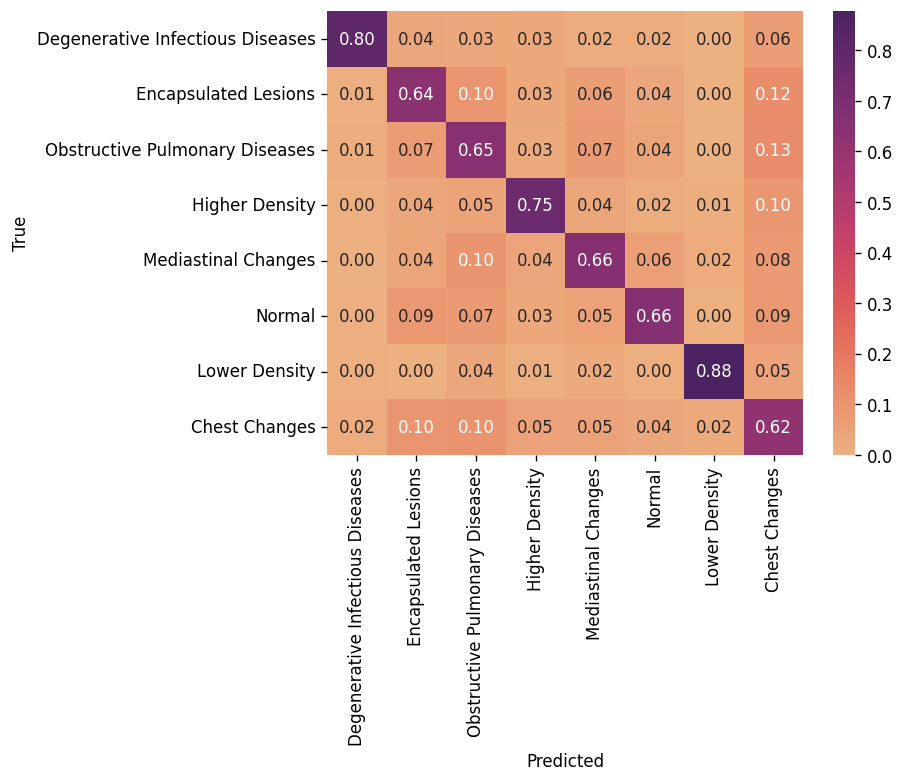

Model weights saved to: /content/drive/MyDrive/DLE602/saved_models/ResNet50_ImageOnly_Adam_CrossEntropyLoss_20_64_0.001.pth


'/content/drive/MyDrive/DLE602/saved_models/ResNet50_ImageOnly_Adam_CrossEntropyLoss_20_64_0.001.pth'

In [75]:
import train

# Construct a unique identifier string for the training run, including
# dataset type, optimizer, loss function, and key hyperparameters.
# This helps in experiment tracking and result reproducibility.
ident_str = f"ImageOnly_{optimizer.__class__.__name__}_{criterion.__class__.__name__}_{epochs}_{batch_size}_{learning_rate}"

# Train the ResNet50 model on the image-only dataset using the specified
# DataLoaders, optimizer, and loss function. The training process will:
#  - Run for the defined number of epochs
#  - Evaluate performance on the validation set each epoch
#  - Log results under the specified project name and identifier string
train.train_model(
    model=model,
    train_loader=train_loader_image,
    val_loader=val_loader_image,
    optimizer=optimizer,
    criterion=criterion,
    class_names=cfg.class_names,
    n_epochs=epochs,
    project_name="DLE602_Assessment_3",
    ident_str=ident_str
    )

## 4.1.2 Merged Dataset

Accuracy_train,▁▄▅▅▆▆▆▇▇▇▇▇▇█▇█████
Accuracy_val,▁▃▄▅▅▆▆▆▇▆▇▇▇▇██████
F1_train,▁▄▄▅▆▆▆▇▇▇▇▇▇█▇█████
F1_val,▁▃▃▅▄▅▆▇▇▆▇▇▇▇██████
Loss_train,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Loss_val,█▆▆▄▄▃▃▃▂▃▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Accuracy_train,0.7673
Accuracy_val,0.71328
F1_train,0.76677
F1_val,0.71999


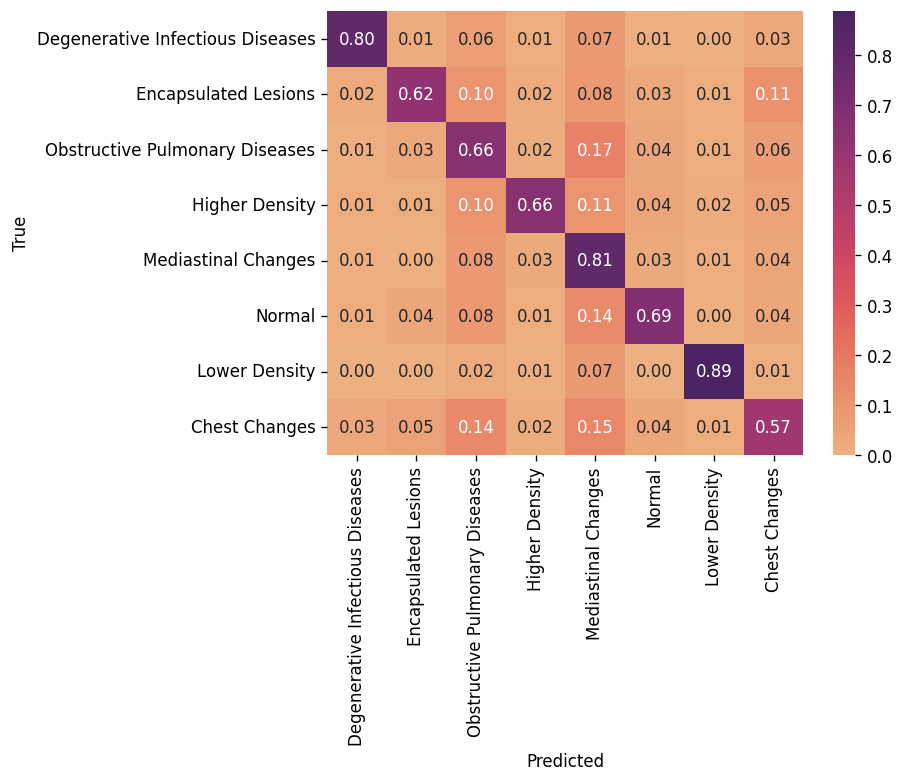

Model weights saved to: /content/drive/MyDrive/DLE602/saved_models/ResNet50_MergedAdam_CrossEntropyLoss_20_64_0.001.pth


'/content/drive/MyDrive/DLE602/saved_models/ResNet50_MergedAdam_CrossEntropyLoss_20_64_0.001.pth'

In [76]:
ident_str = f"Merged{optimizer.__class__.__name__}_{criterion.__class__.__name__}_{epochs}_{batch_size}_{learning_rate}"


train.train_model(
    model=model,
    train_loader=train_loader_merged,
    val_loader=val_loader_merged,
    optimizer=optimizer,
    criterion=criterion,
    class_names=cfg.class_names,
    n_epochs=epochs,
    project_name="DLE602_Assessment_3",
    ident_str=ident_str
    )

## 4.2 MobileNet V3 small

## 4.2.1 Image-Only Dataset

Accuracy_train,▁▄▆▆▇▇▇▇▇▇██████████
Accuracy_val,▁▁▂▃▄▆▇▇████████████
F1_train,▁▄▆▆▇▇▇▇▇▇██████████
F1_val,▁▁▁▃▄▇▇▇████████████
Loss_train,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Loss_val,██▇▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Accuracy_train,0.78136
Accuracy_val,0.78073
F1_train,0.78046
F1_val,0.7795


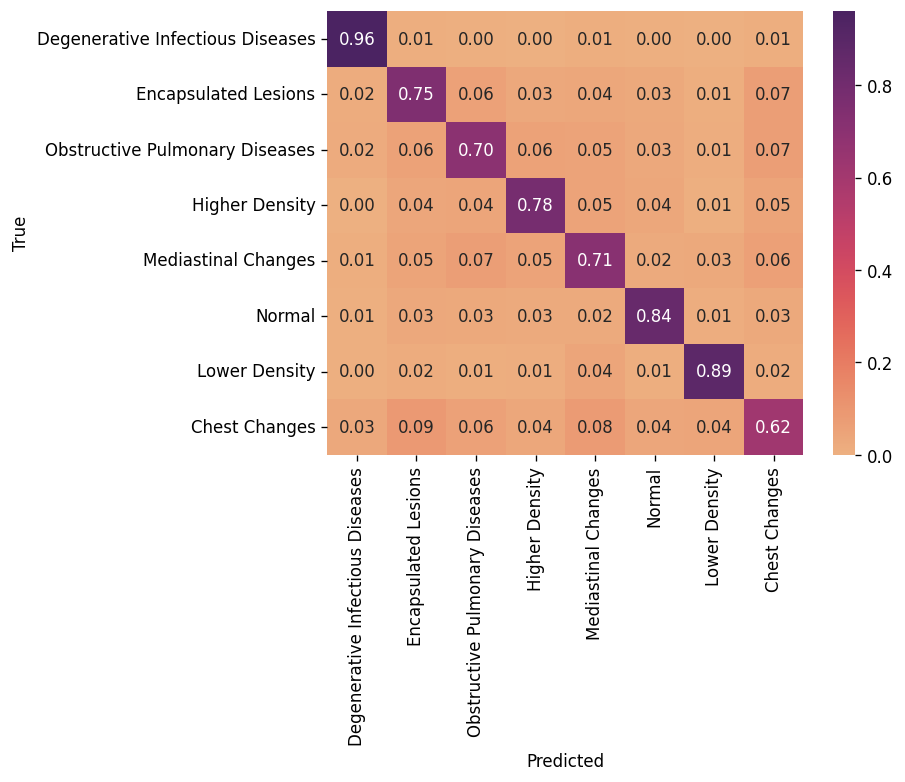

Model weights saved to: /content/drive/MyDrive/DLE602/saved_models/MobileNetV3Small_Image_only_Adam_CrossEntropyLoss_20_64_0.001.pth


'/content/drive/MyDrive/DLE602/saved_models/MobileNetV3Small_Image_only_Adam_CrossEntropyLoss_20_64_0.001.pth'

In [77]:
model = models.MobileNetV3Small(number_of_classes=cfg.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

ident_str = f"Image_only_{optimizer.__class__.__name__}_{criterion.__class__.__name__}_{epochs}_{batch_size}_{learning_rate}"

train.train_model(
    model=model,
    train_loader=train_loader_image,
    val_loader=val_loader_image,
    optimizer=optimizer,
    criterion=criterion,
    class_names=cfg.class_names,
    n_epochs=epochs,
    project_name="DLE602_Assessment_3",
    ident_str=ident_str
    )

## 4.2.2 Merged Dataset

Accuracy_train,▁▄▅▆▆▇▇▇▇▇▇█████████
Accuracy_val,▂▁▂▃▅▇▇█████████████
F1_train,▁▄▅▆▆▇▇▇▇▇▇█████████
F1_val,▂▁▁▃▅▇▇█████████████
Loss_train,█▅▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
Loss_val,▇██▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Accuracy_train,0.76786
Accuracy_val,0.75677
F1_train,0.76695
F1_val,0.75472


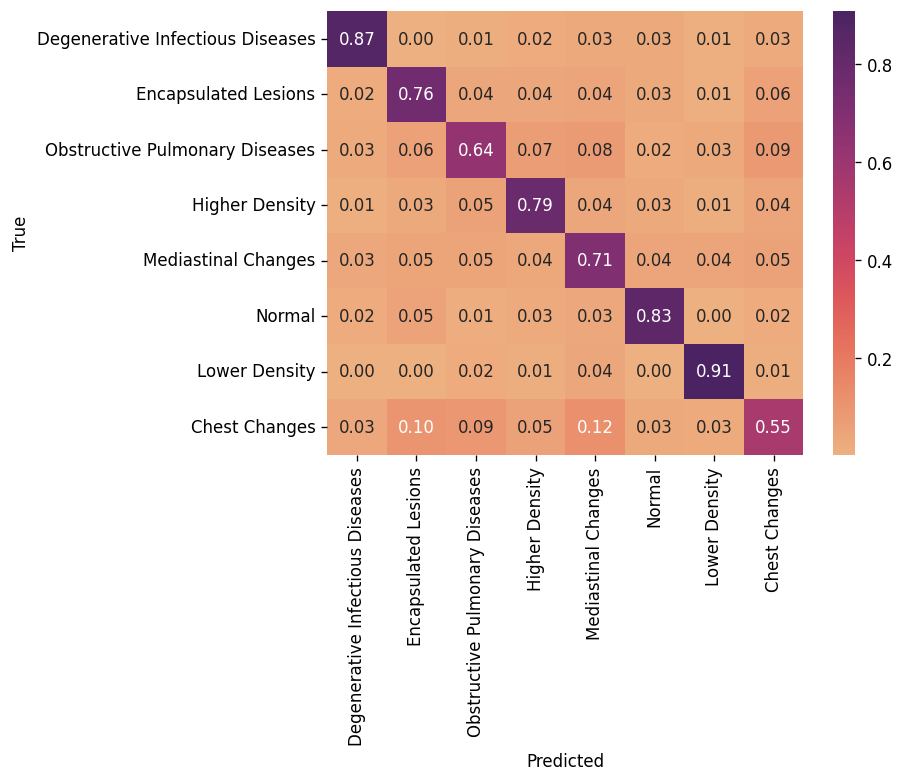

Model weights saved to: /content/drive/MyDrive/DLE602/saved_models/MobileNetV3Small_Merged_Adam_CrossEntropyLoss_20_64_0.001.pth


'/content/drive/MyDrive/DLE602/saved_models/MobileNetV3Small_Merged_Adam_CrossEntropyLoss_20_64_0.001.pth'

In [78]:
model = models.MobileNetV3Small(number_of_classes=cfg.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

ident_str = f"Merged_{optimizer.__class__.__name__}_{criterion.__class__.__name__}_{epochs}_{batch_size}_{learning_rate}"

train.train_model(
    model=model,
    train_loader=train_loader_merged,
    val_loader=val_loader_merged,
    optimizer=optimizer,
    criterion=criterion,
    class_names=cfg.class_names,
    n_epochs=epochs,
    project_name="DLE602_Assessment_3",
    ident_str=ident_str
    )

## 4.3 Custom CNN model with residual/skip block

The CustomResidualCNN is a lightweight classifier that standardizes inputs to 224×224 and uses stride-based downsampling in place of max pooling. The network begins with a stem (3→32 channels) comprising a 3×3 convolution with stride 2, ReLU, and BatchNorm. Feature refinement and channel expansion are performed by a residual block (SkipBlock, 32→64) consisting of two consecutive 3×3 Conv–ReLU–BN stages with a residual (element-wise) addition between the block output and its intermediate activation. A second downsampling stage (3×3, stride 2) increases capacity to 128 channels, followed by Global Average Pooling (GAP) to reduce the spatial dimension to 1×1, thus minimizing parameters and overfitting risk. The classifier head is intentionally compact—Flatten → Linear(128→64) → ReLU → BN → Dropout(0.3) → Linear(64→C)—producing logits over the target classes. The design emphasizes (i) parameter efficiency (GAP instead of large fully connected layers), (ii) stable training (BatchNorm after convolutions and in the head), and (iii) representational depth via a residual refinement block without heavy computational cost.

Tensor shapes (for 224×224 input)
-	**Input**: (B, 3, 224, 224)
-	**Resize**: (B, 3, 224, 224)  (idempotent if already 224²)
-	**Stage 1 (Conv3×3 s=2, 3→32)**: (B, 32, 112, 112)
-	**SkipBlock (two Conv3×3, 32→64)**: (B, 64, 112, 112)
-	**Stage 2 (Conv3×3 s=2, 64→128)**: (B, 128, 56, 56)
-	**Global Average Pooling**: (B, 128, 1, 1)
-	**Classifier**: (B, 128) → (B, 64) → (B, C)

Architecture Diagram : https://drive.google.com/file/d/1SDNPEJa4KHjKHaZgy8aM46eCyqKZvqxu/view?usp=sharing

## 4.3.1 Image-Only Dataset

Accuracy_train,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇████
Accuracy_val,▁▃▄▄▅▄▅▆▆▆▇▇▇▆▇▇▇▇██
F1_train,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇████
F1_val,▁▃▄▄▅▄▅▆▆▆▆▇▇▆▇▇▇▇██
Loss_train,█▇▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁
Loss_val,█▆▅▅▄▅▄▃▃▃▂▂▂▃▂▂▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Accuracy_train,0.88393
Accuracy_val,0.8875
F1_train,0.88375
F1_val,0.89061


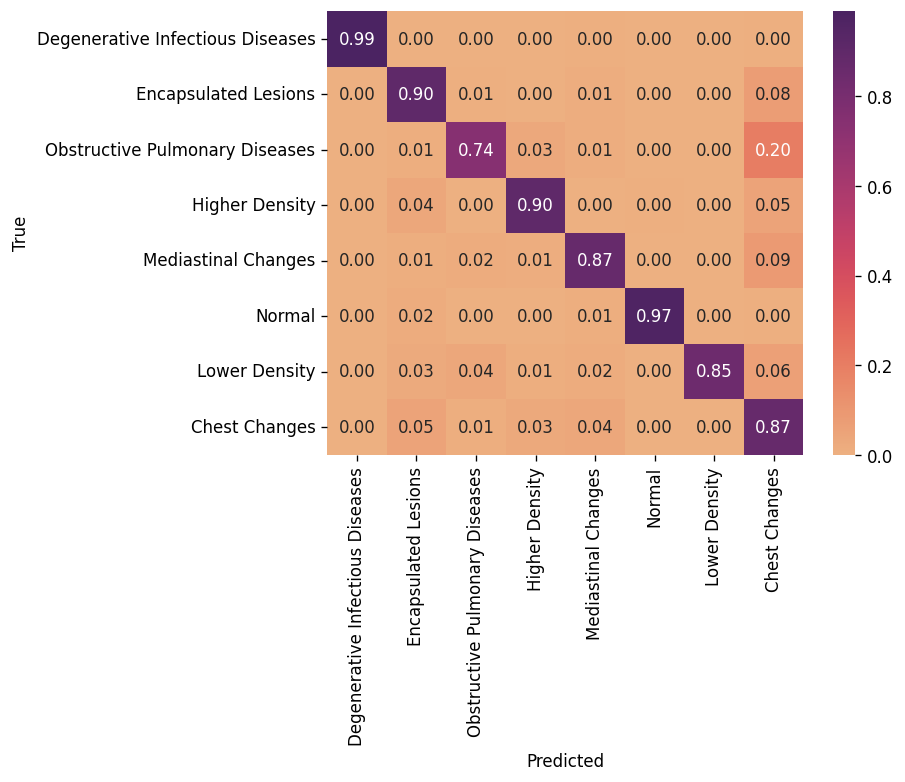

Model weights saved to: /content/drive/MyDrive/DLE602/saved_models/CustomResidualCNN_Image_only_Adam_CrossEntropyLoss_20_64_0.001.pth


'/content/drive/MyDrive/DLE602/saved_models/CustomResidualCNN_Image_only_Adam_CrossEntropyLoss_20_64_0.001.pth'

In [79]:
model = models.CustomResidualCNN(number_of_classes=cfg.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

ident_str = f"Image_only_{optimizer.__class__.__name__}_{criterion.__class__.__name__}_{epochs}_{batch_size}_{learning_rate}"

train.train_model(
    model=model,
    train_loader=train_loader_image,
    val_loader=val_loader_image,
    optimizer=optimizer,
    criterion=criterion,
    class_names=cfg.class_names,
    n_epochs=epochs,
    project_name="DLE602_Assessment_3",
    ident_str=ident_str
    )

## 4.3.2 Merged Dataset

Accuracy_train,▁▂▄▅▆▇▇▇▇███████████
Accuracy_val,▂▂▁▂▁▂▃▄▁▂▄▃▆█▄▁▄▇▅▆
F1_train,▁▂▄▅▆▇▇▇▇███████████
F1_val,▂▂▁▂▂▂▃▄▁▂▄▃▆█▄▁▄▇▅▇
Loss_train,█▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Loss_val,▂▃█▄▇▃▄▂▆▄▂▄▁▁▂█▃▁▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Accuracy_train,0.97054
Accuracy_val,0.74844
F1_train,0.97055
F1_val,0.76389


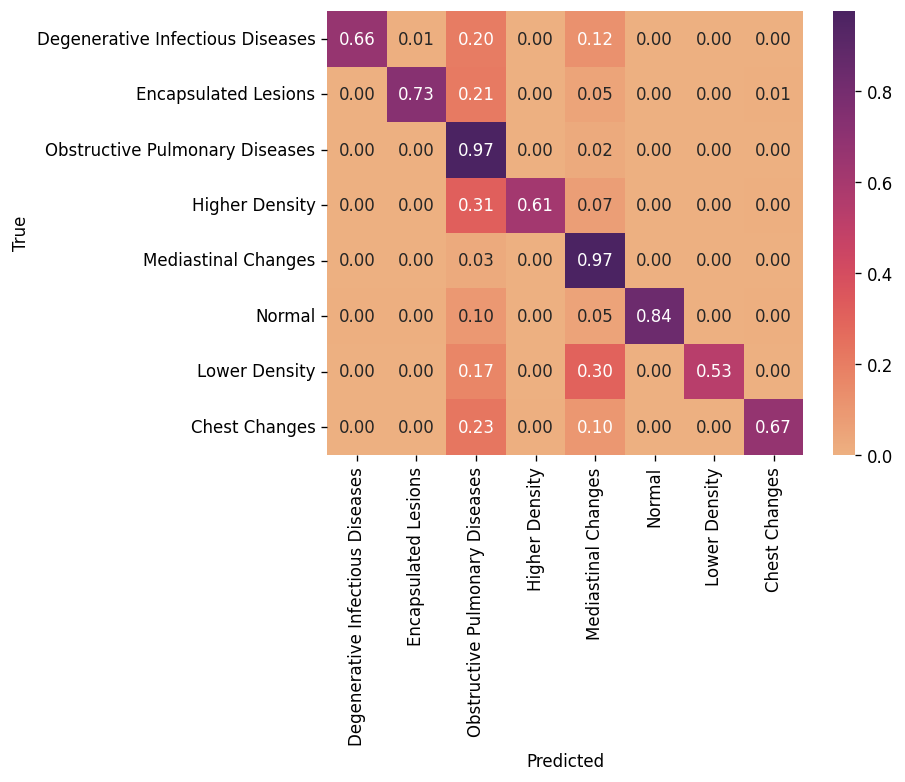

Model weights saved to: /content/drive/MyDrive/DLE602/saved_models/CustomResidualCNN_Merged_Adam_CrossEntropyLoss_20_64_0.001.pth


'/content/drive/MyDrive/DLE602/saved_models/CustomResidualCNN_Merged_Adam_CrossEntropyLoss_20_64_0.001.pth'

In [80]:
model = models.CustomResidualCNN(number_of_classes=cfg.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

ident_str = f"Merged_{optimizer.__class__.__name__}_{criterion.__class__.__name__}_{epochs}_{batch_size}_{learning_rate}"

train.train_model(
    model=model,
    train_loader=train_loader_merged,
    val_loader=val_loader_merged,
    optimizer=optimizer,
    criterion=criterion,
    class_names=cfg.class_names,
    n_epochs=epochs,
    project_name="DLE602_Assessment_3",
    ident_str=ident_str
    )